In [1]:
from Extract_ephys_from_struct import ExtractEphysData, calculate_mean_responses, ResponseDistributionPlotter

#from plotting_functions import plot_spike_distribution_boxplots, plot_spike_distribution, plot_psth, plot_raster

#now test the class
#initialize the class
EED = ExtractEphysData('/Users/cresp1el/Documents/MATLAB/lmc_20ms_data.mat')

#test the methods of the class
EED.load_matfiles_printdata()

#test the extract_ephys_data method
# EED.extract_ephys_data('Lmc_opsin', 'lmc_ch_1_3094_rec1', 'cid134')

#what are the group names?

EED.group_names

dict_keys(['Lmc_noopsin', 'Lmc_opsin'])
For the group Lmc_noopsin there are 2 mice
For the recording lmc_noch_1_3096_rec1 there are 5 cells
For the recording lmc_noch_1_3096_rec2 there are 4 cells
For the group Lmc_opsin there are 3 mice
For the recording lmc_ch_1_3094_rec1 there are 7 cells
For the recording lmc_ch_1_3094_rec2 there are 3 cells
For the recording lmc_ch_2_3093_rec1 there are 4 cells


dict_keys(['Lmc_noopsin', 'Lmc_opsin'])

In [2]:
test = calculate_mean_responses(EED)

In [3]:
print(test.keys()) #these are the group names
print(test['Lmc_opsin'].keys()) #these are the pre and post epoch names for each group
print(test['Lmc_opsin']['Pre']) #these are the cell names for each epoch

dict_keys(['Lmc_noopsin', 'Lmc_opsin'])
dict_keys(['Pre', 'Post'])
[{'Recording': 'lmc_ch_1_3094_rec1', 'CellID': 'cid134', 'Pre_Zero_early': 0.0975609756097561, 'Pre_Zero_late': 1.991869918699187, 'Pre_Low_early': 0.13846153846153847, 'Pre_Low_late': 1.4, 'Pre_Mid_early': 0.17777777777777778, 'Pre_Mid_late': 1.962962962962963, 'Pre_Max_early': 0.15789473684210525, 'Pre_Max_late': 1.7982456140350878, 'Pre_Pooled_early': 0.158311345646438, 'Pre_Pooled_late': 1.720316622691293, 'Post_Zero_early': 0.12962962962962962, 'Post_Zero_late': 1.5277777777777777, 'Post_Low_early': 0.06779661016949153, 'Post_Low_late': 1.652542372881356, 'Post_Mid_early': 0.03731343283582089, 'Post_Mid_late': 1.8208955223880596, 'Post_Max_early': 0.12903225806451613, 'Post_Max_late': 1.653225806451613, 'Post_Pooled_early': 0.07712765957446809, 'Post_Pooled_late': 1.7127659574468086}, {'Recording': 'lmc_ch_1_3094_rec1', 'CellID': 'cid145', 'Pre_Zero_early': 0.37398373983739835, 'Pre_Zero_late': 5.5528455284552845, 

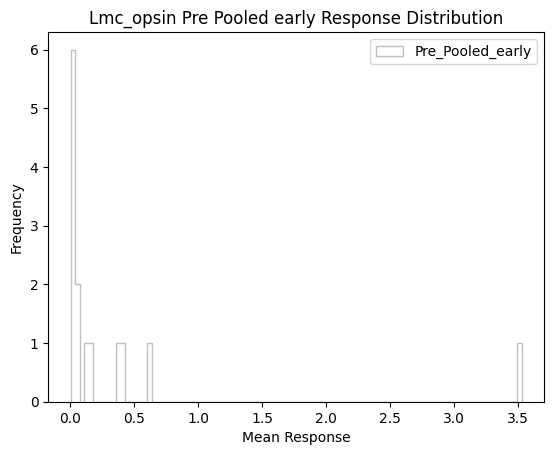

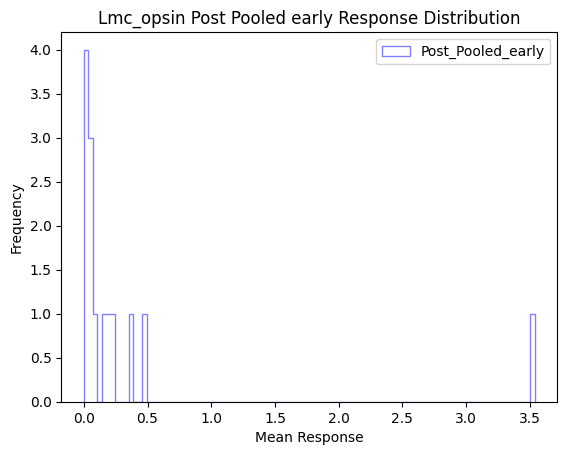

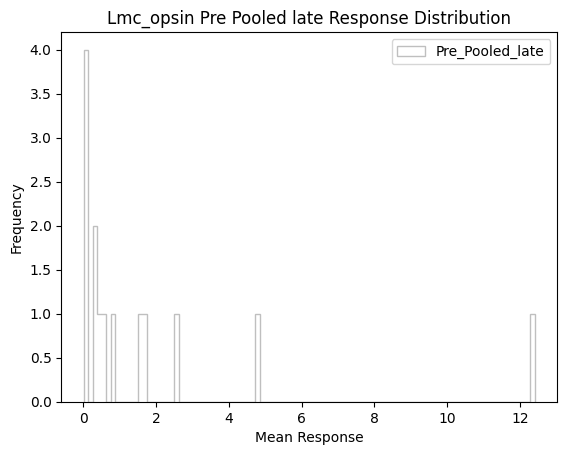

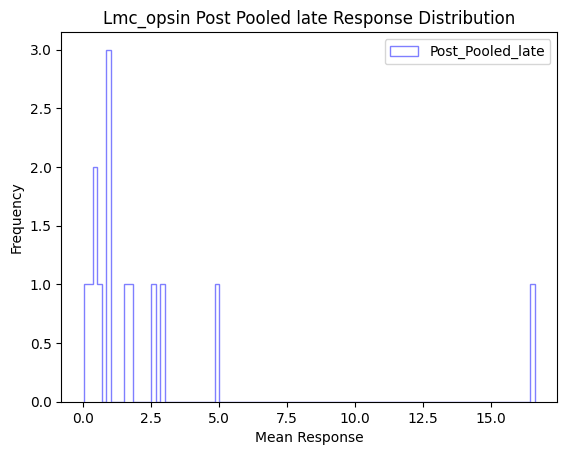

In [4]:
# Assuming `mean_responses_data` is the dictionary obtained from the calculate_mean_responses function
plotter = ResponseDistributionPlotter(test)
plotter.plot_distribution('Lmc_opsin', 'Pre', 'Pooled', bins=100, overlay=True, phase='early') 
plotter.plot_distribution('Lmc_opsin', 'Post', 'Pooled', bins=100, overlay=True, phase='early')

# Assuming `mean_responses_data` is the dictionary obtained from the calculate_mean_responses function
plotter = ResponseDistributionPlotter(test)
plotter.plot_distribution('Lmc_opsin', 'Pre', 'Pooled', bins=100, overlay=True, phase='late') 
plotter.plot_distribution('Lmc_opsin', 'Post', 'Pooled', bins=100, overlay=True, phase='late')

KeyError: None

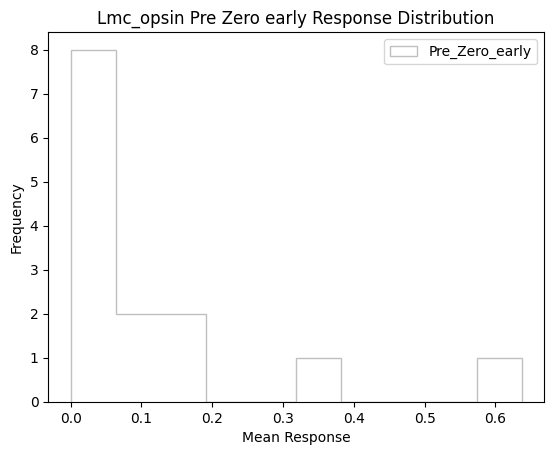

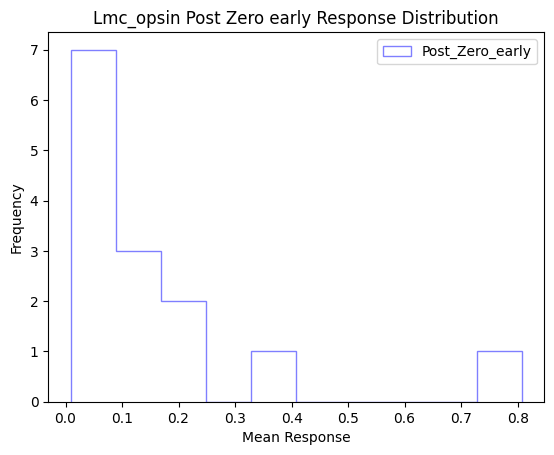

In [5]:

# plotter.plot_distribution('Lmc_opsin', epoch=None, stim_level='Zero', overlay=True)
#plot the distribution for pre and post stim levels separately
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Zero', overlay=True)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Zero', overlay=True)

# Plotting 'Pre' and 'Post' distributions on top of each other by setting overlay=True 
#loop over the 'Zero', 'Low', 'Mid', 'Max', or 'Pooled' stim levels to plot the distributions for each stim level
for stim_level in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']: 
    plotter.plot_distribution('Lmc_opsin', epoch=None, stim_level=stim_level, overlay=True)
    
    

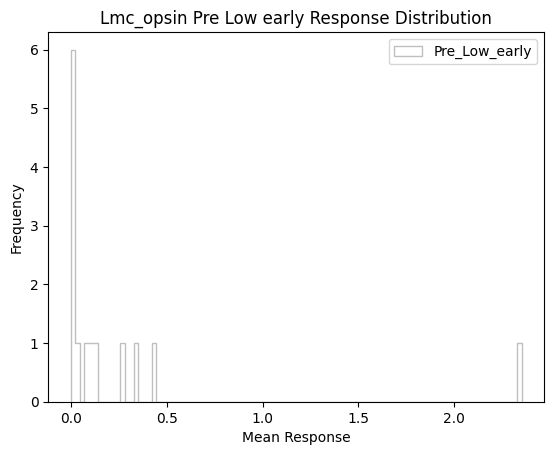

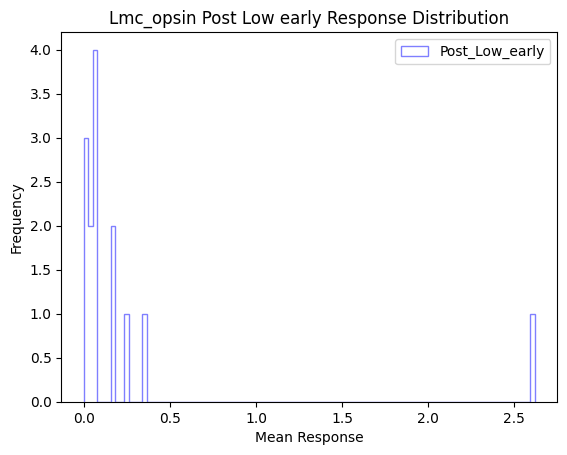

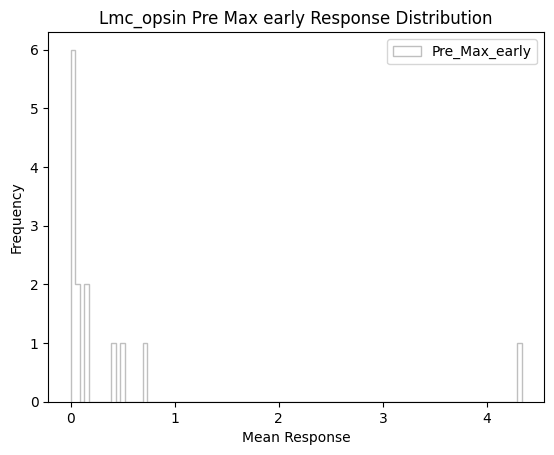

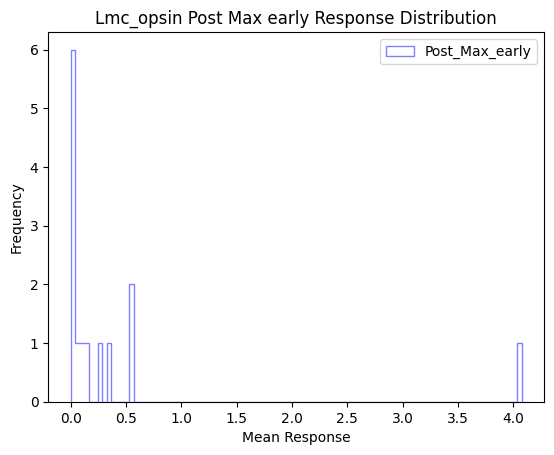

In [6]:
#plot the pre and post for the low separated 
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Low', bins=100)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Low', bins=100)

#plot the pre and post for the high separated
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Max', bins=100)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Max', bins=100)


In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        bp = plt.boxplot(stim_data, positions=position, labels=stim_levels if i == 0 else [''] * len(stim_levels), patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level')
    
    # Adding epoch labels
    if epoch == 'both':
        mid_point = len(stim_levels) / 2
        plt.text(mid_point, plt.gca().get_ylim()[1], 'Pre', ha='center', va='center', fontsize=12, fontweight='bold')
        plt.text(len(stim_levels) + 1 + mid_point, plt.gca().get_ylim()[1], 'Post', ha='center', va='center', fontsize=12, fontweight='bold')

    # Show the plot
    if not overlay:
        plt.show()

# Usage example:
# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Zero', 'both')





KeyError: 'Pre_Zero'

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        labels = [f'{epoch}{level}' for level in stim_levels]
        bp = plt.boxplot(stim_data, positions=position, labels=labels, patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level Epoch')
    
    # Show the plot
    if not overlay:
        plt.show()



# Usage example:

# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Max', 'both')


KeyError: 'Pre_Max'

In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False, plot_hist=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    - plot_hist (bool): Whether to plot the histogram distribution. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        labels = [f'{epoch}_{level}' for level in stim_levels]
        bp = plt.boxplot(stim_data, positions=position, labels=labels, patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level Epoch')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)
    
    # Plot the histogram distribution if specified
    if plot_hist:
        plt.figure()
        for epoch in epochs_to_plot:
            for stim_level in stim_levels:
                stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
                plt.hist(stim_data, alpha=0.5, label=f'{epoch}_{stim_level}', color=colors[epoch], histtype='step')
        plt.xlabel('Mean Response')
        plt.ylabel('Frequency')
        plt.title(f'{group_name} Response Distributions')
        plt.legend()
    
    # Show the plot
    if not overlay:
        plt.show()


# Usage example:
# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Zero', 'both', plot_hist=True)

# Assuming `data_dict` is your data dictionary obtained from your data processing
plot_box_and_whisker(test, group_name='Lmc_opsin')


KeyError: 'Pre_Zero'

In [10]:
# Example 1: Basic Usage with Default Parameters
plot_box_and_whisker(test, group_name='Lmc_opsin')

#Example 2: Plotting for a Single Epoch with Histograms
plot_box_and_whisker(test, group_name='Lmc_opsin', epoch='Pre', plot_hist=True)

#Example 3: Plotting for Specific Stimulation Levels 
plot_box_and_whisker(test, group_name='Lmc_opsin', stim_levels=['Zero', 'Max'], plot_hist=True)

#Example 4: Overlaying 'Pre' and 'Post' Data on a Single Plot
plot_box_and_whisker(test, group_name='Lmc_opsin', overlay=True)

# Example 5: Plotting for a Single Stimulation Level
plot_box_and_whisker(test, group_name='Lmc_opsin', stim_levels='Zero', plot_hist=True)

KeyError: 'Pre_Zero'

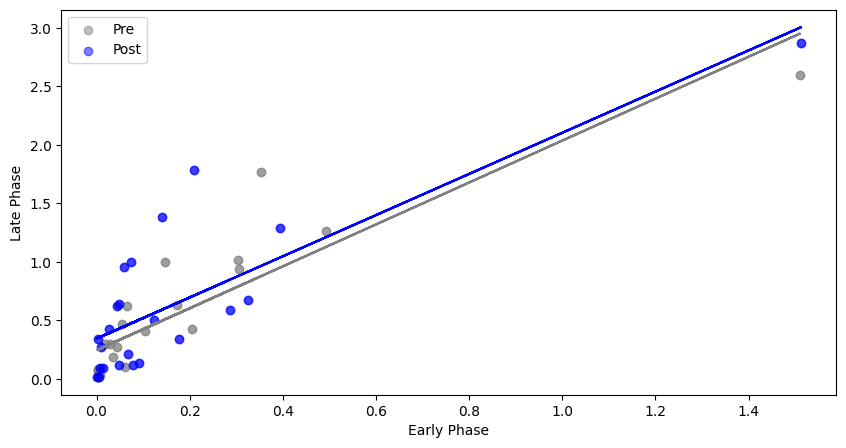

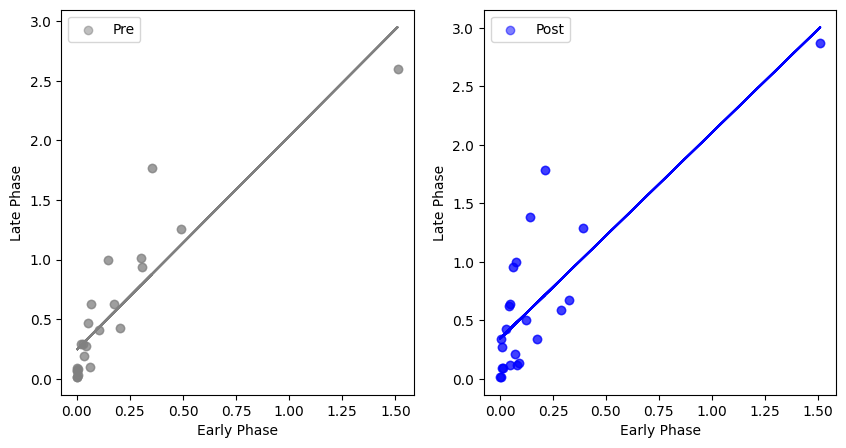

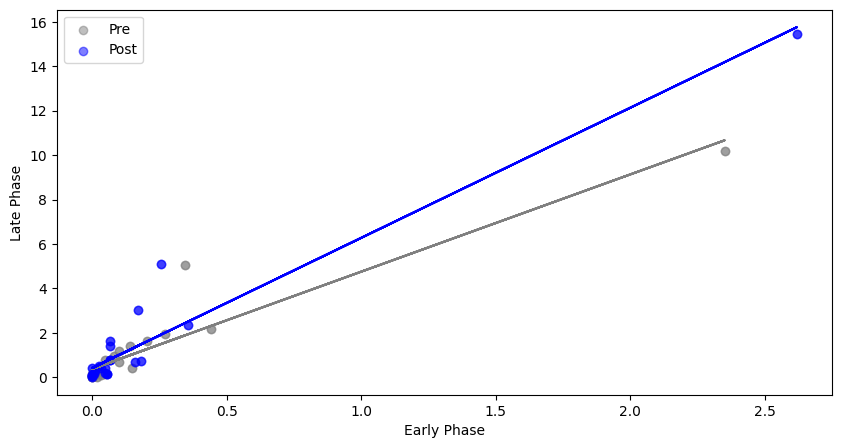

In [11]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(data, stimulation='Pooled', overlay=True, log_scale=False):
    
    pre_early = []
    pre_late = []
    post_early = []
    post_late = []

    for group in data.values():
        for epoch_data in group.values():
            for record in epoch_data:
                pre_early.append(record[f'Pre_{stimulation}_early'])
                pre_late.append(record[f'Pre_{stimulation}_late'])
                post_early.append(record[f'Post_{stimulation}_early'])
                post_late.append(record[f'Post_{stimulation}_late'])

    fig, ax = plt.subplots(1, 2 if not overlay else 1, figsize=(10, 5))

    if log_scale:
        pre_early = [np.log(x+1) for x in pre_early]
        pre_late = [np.log(x+1) for x in pre_late]
        post_early = [np.log(x+1) for x in post_early]
        post_late = [np.log(x+1) for x in post_late]

    if overlay:
        ax.scatter(pre_early, pre_late, color='grey', alpha=0.5, label='Pre')
        ax.scatter(post_early, post_late, color='blue', alpha=0.5, label='Post')
        
        # Adding simple linear regression lines
        slope, intercept, _, _, _ = stats.linregress(pre_early, pre_late)
        ax.plot(pre_early, np.array(pre_early)*slope + intercept, color='grey')
        
        slope, intercept, _, _, _ = stats.linregress(post_early, post_late)
        ax.plot(post_early, np.array(post_early)*slope + intercept, color='blue')
        
        ax.set_xlabel('Early Phase')
        ax.set_ylabel('Late Phase')
    else:
        ax[0].scatter(pre_early, pre_late, color='grey', alpha=0.5, label='Pre')
        ax[1].scatter(post_early, post_late, color='blue', alpha=0.5, label='Post')
        
        # Adding simple linear regression lines
        slope, intercept, _, _, _ = stats.linregress(pre_early, pre_late)
        ax[0].plot(pre_early, np.array(pre_early)*slope + intercept, color='grey')
        
        slope, intercept, _, _, _ = stats.linregress(post_early, post_late)
        ax[1].plot(post_early, np.array(post_early)*slope + intercept, color='blue')
        
        ax[0].set_xlabel('Early Phase')
        ax[0].set_ylabel('Late Phase')
        ax[1].set_xlabel('Early Phase')
        ax[1].set_ylabel('Late Phase')
        
        ax[0].legend()

    plt.legend()
    plt.show()

# Example commands to test the function
# Replace 'test' with your actual data dictionary
plot_regression(test, stimulation='Pooled', overlay=True, log_scale=True)
plot_regression(test, stimulation='Pooled', overlay=False, log_scale=True)
plot_regression(test, stimulation='Low', overlay=True, log_scale=False)


In [12]:
print(type(test['Lmc_opsin']['Pre'])) #prints the type of the data
print(len(test['Lmc_opsin']['Pre'])) #print the number of units in the pre epoch of the Lmc_opsin group
print(test['Lmc_opsin']['Pre'][0].keys()) #print the keys of the first element in the list 

<class 'list'>
14
dict_keys(['Recording', 'CellID', 'Pre_Zero_early', 'Pre_Zero_late', 'Pre_Low_early', 'Pre_Low_late', 'Pre_Mid_early', 'Pre_Mid_late', 'Pre_Max_early', 'Pre_Max_late', 'Pre_Pooled_early', 'Pre_Pooled_late', 'Post_Zero_early', 'Post_Zero_late', 'Post_Low_early', 'Post_Low_late', 'Post_Mid_early', 'Post_Mid_late', 'Post_Max_early', 'Post_Max_late', 'Post_Pooled_early', 'Post_Pooled_late'])


In [13]:
print(type(test['Lmc_opsin']['Pre'])) #prints the type of the data
print(len(test['Lmc_opsin']['Pre'])) #print the number of units in the pre epoch of the Lmc_opsin group
print(test['Lmc_opsin']['Pre'][0].keys()) #print the keys of the first element in the list 

<class 'list'>
14
dict_keys(['Recording', 'CellID', 'Pre_Zero_early', 'Pre_Zero_late', 'Pre_Low_early', 'Pre_Low_late', 'Pre_Mid_early', 'Pre_Mid_late', 'Pre_Max_early', 'Pre_Max_late', 'Pre_Pooled_early', 'Pre_Pooled_late', 'Post_Zero_early', 'Post_Zero_late', 'Post_Low_early', 'Post_Low_late', 'Post_Mid_early', 'Post_Mid_late', 'Post_Max_early', 'Post_Max_late', 'Post_Pooled_early', 'Post_Pooled_late'])


In [14]:
from scipy import stats
import numpy as np

def calculate_pearson_correlations(EED, group_name=None):
    """
    Calculate the Pearson correlation coefficients using the individual trial responses from both the early and late windows during both the pre and post epochs for each unit.

    Parameters:
    EED (object): The object containing the electrophysiology data.
    group_name (str, optional): The name of the group to analyze. Defaults to None, in which case all groups are analyzed.

    Returns:
    dict: A dictionary containing the Pearson correlation coefficients for each unit.
    """
    
    # Get list of group names
    group_names = [group_name] if group_name else EED.group_names
    
    # Dictionary to store the Pearson correlation coefficients for each group
    pearson_correlations = {}
    
    # Loop through each group
    for group in group_names:
        recording_names = EED.get_recording_names(group)
        
        # Dictionary to store the Pearson correlation coefficients for all units in the current group
        group_pearson_correlations = {'Pre': [], 'Post': []}
        
        # Loop through each recording
        for recording in recording_names:
            cellid_names = EED.get_cellid_names(group, recording)
            
            # Loop through each cell ID
            for cell_id in cellid_names:
                # Get the pre and post stim data
                data = EED.get_pre_post_data(group, recording, cell_id)
                
                # Define stimulation levels and pooled stimulation levels
                stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']
                
                # Dictionary to store the Pearson correlation coefficients for the current unit
                unit_pearson_correlations = {'Recording': recording, 'CellID': cell_id}
                
                # Loop through each epoch (pre and post) and stimulation level to calculate Pearson correlation coefficients
                for epoch in ['Pre', 'Post']:
                    for stim_level in stim_levels:
                        if stim_level == 'Pooled':
                            stim_indices = [1, 2, 3]
                        else:
                            stim_indices = [stim_levels.index(stim_level)]
                        
                        # Get spike trains for the current stimulation level
                        spiketrains = np.concatenate([data[epoch]['SpikeTrains_for_PSTHs'][i] for i in stim_indices], axis=0)
                        
                        # Extract spike data for the early phase (0-50 ms post-stimulus)
                        early_phase = spiketrains[:, 500:550]  # Adjust indices as necessary
                        
                        # Extract spike data for the late phase (100-700 ms post-stimulus)
                        late_phase = spiketrains[:, 600:1200]  # Adjust indices as necessary
                        
                        # Calculate the total number of spikes in each trial during the early and late phases
                        early_response = early_phase.sum(axis=1)
                        late_response = late_phase.sum(axis=1)
                        
                        # Calculate the Pearson correlation coefficient for the early and late responses
                        corr, _ = stats.pearsonr(early_response, late_response)
                        
                        # Add the Pearson correlation coefficient to the dictionary
                        unit_pearson_correlations[f'{epoch}_{stim_level}_Pearson_Correlation'] = corr
                
                # Calculate the difference between post and pre Pearson correlation coefficients for each stimulation level
                for stim_level in stim_levels:
                    pre_corr = unit_pearson_correlations[f'Pre_{stim_level}_Pearson_Correlation']
                    post_corr = unit_pearson_correlations[f'Post_{stim_level}_Pearson_Correlation']
                    unit_pearson_correlations[f'{stim_level}_Correlation_Difference'] = post_corr - pre_corr
                
                # Add the Pearson correlation coefficients for the current unit to the list
                group_pearson_correlations['Pre'].append(unit_pearson_correlations)
                group_pearson_correlations['Post'].append(unit_pearson_correlations)
        
        # Add the Pearson correlation coefficients for the current group to the dictionary
        pearson_correlations[group] = group_pearson_correlations
    
    return pearson_correlations


# use the function
pearson_correlations = calculate_pearson_correlations(EED, group_name=None)

/Users/cresp1el/anaconda3/envs/matlab_python_proj/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [15]:
pearson_correlations.keys() #prints the keys of the dictionary
pearson_correlations['Lmc_opsin'].keys() 
pearson_correlations['Lmc_opsin']['Pre'][0]

{'Recording': 'lmc_ch_1_3094_rec1',
 'CellID': 'cid134',
 'Pre_Zero_Pearson_Correlation': 0.15509552412157396,
 'Pre_Low_Pearson_Correlation': 0.354355950106479,
 'Pre_Mid_Pearson_Correlation': 0.45576292996659434,
 'Pre_Max_Pearson_Correlation': 0.004429962470185532,
 'Pre_Pooled_Pearson_Correlation': 0.2933269450320374,
 'Post_Zero_Pearson_Correlation': 0.6844623299373095,
 'Post_Low_Pearson_Correlation': 0.18403810946543847,
 'Post_Mid_Pearson_Correlation': 0.4536387969236069,
 'Post_Max_Pearson_Correlation': 0.12297178095998822,
 'Post_Pooled_Pearson_Correlation': 0.2033400880925984,
 'Zero_Correlation_Difference': 0.5293668058157355,
 'Low_Correlation_Difference': -0.17031784064104055,
 'Mid_Correlation_Difference': -0.0021241330429874195,
 'Max_Correlation_Difference': 0.11854181848980269,
 'Pooled_Correlation_Difference': -0.08998685693943898}

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/3211007642.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/3211007642.py:51: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Correlation Difference')


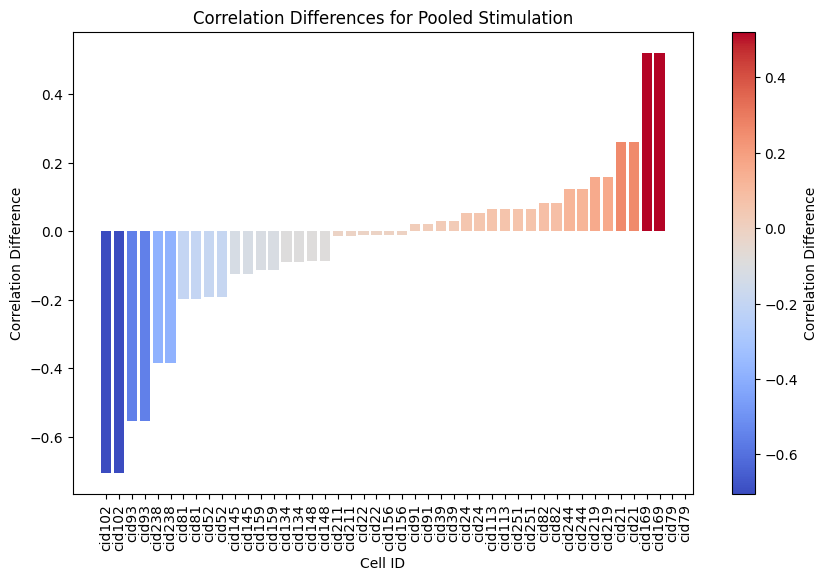

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_correlation_differences(correlation_data, stimulation_level):
    """
    Plot the correlation differences for all units, ranked from least to most, for a specified stimulation level.

    Parameters:
    correlation_data (dict): The dictionary containing the Pearson correlation data for each unit.
    stimulation_level (str): The stimulation level to plot (one of 'Zero', 'Low', 'Mid', 'Max', 'Pooled').

    Returns:
    None: The function will plot the data but not return any values.
    """
    
    # List to store all units and their correlation differences
    all_units_correlation_differences = []
    
    # Loop through each group in the correlation data
    for group_name, group_data in correlation_data.items():
        # Loop through each epoch (pre and post) to get the units and their correlation differences
        for epoch_name, epoch_data in group_data.items():
            # Loop through each unit to get its correlation difference for the specified stimulation level
            for unit in epoch_data:
                # Get the correlation difference for the current unit and the specified stimulation level
                correlation_difference = unit[f'{stimulation_level}_Correlation_Difference']
                # Get the cell ID for the current unit
                cell_id = unit['CellID']
                # Add the unit's cell ID and correlation difference to the list
                all_units_correlation_differences.append((cell_id, correlation_difference))
    
    # Sort the units by their correlation differences from least to most
    sorted_units = sorted(all_units_correlation_differences, key=lambda x: x[1])
    
    # Get the cell IDs and correlation differences as separate lists
    cell_ids, correlation_differences = zip(*sorted_units)
    
    # Create a bar plot of the correlation differences
    plt.figure(figsize=(10, 6))
    
    # Create a colormap for the bar colors
    norm = mcolors.Normalize(vmin=min(correlation_differences), vmax=max(correlation_differences))
    cmap = plt.cm.get_cmap('coolwarm')
    
    # Create a bar plot with colors based on the correlation differences
    plt.bar(range(len(correlation_differences)), correlation_differences, tick_label=cell_ids, color=cmap(norm(correlation_differences)))
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Correlation Difference')
    
    # Add labels and title to the plot
    plt.xlabel('Cell ID')
    plt.ylabel('Correlation Difference')
    plt.title(f'Correlation Differences for {stimulation_level} Stimulation')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)
    
    
    
    # Display the plot
    plt.show()

    
#run the function
# plot_correlation_differences(pearson_correlations, 'Pooled')

#now for the low stimulation
plot_correlation_differences(pearson_correlations, 'Pooled')


In [19]:
print(list(pearson_correlations.values())[0].keys())

dict_keys(['Pre', 'Post'])


/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/1991625985.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/1991625985.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Correlation Difference')


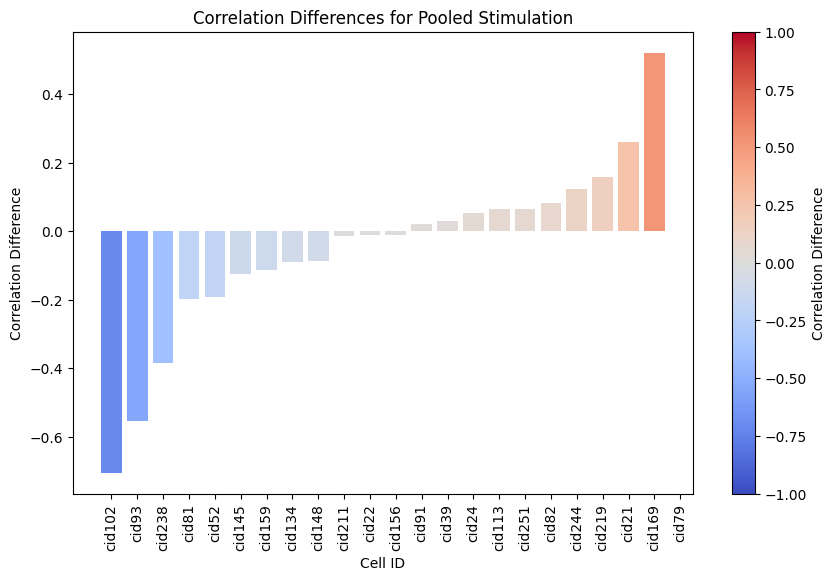

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_correlation_differences(correlation_data, stimulation_level):
    """
    Plot the correlation differences for all units, ranked from least to most, for a specified stimulation level.

    Parameters:
    correlation_data (dict): The dictionary containing the Pearson correlation data for each unit.
    stimulation_level (str): The stimulation level to plot (one of 'Zero', 'Low', 'Mid', 'Max', 'Pooled').

    Returns:
    None: The function will plot the data but not return any values.
    """
    
    # List to store all units and their correlation differences
    all_units_correlation_differences = []
    
    # Loop through each group in the correlation data
    for group_name, group_data in correlation_data.items():
        # Get the 'Pre' epoch data to get the units and their correlation differences
        epoch_data = group_data['Pre']
        
        # Loop through each unit to get its correlation difference for the specified stimulation level
        for unit in epoch_data:
            # Get the correlation difference for the current unit and the specified stimulation level
            correlation_difference = unit[f'{stimulation_level}_Correlation_Difference']
            # Get the cell ID for the current unit
            cell_id = unit['CellID']
            # Add the unit's cell ID and correlation difference to the list
            all_units_correlation_differences.append((cell_id, correlation_difference))
    
    # Sort the units by their correlation differences from least to most
    sorted_units = sorted(all_units_correlation_differences, key=lambda x: x[1])
    
    # Get the cell IDs and correlation differences as separate lists
    cell_ids, correlation_differences = zip(*sorted_units)
    
    # Create a bar plot of the correlation differences
    plt.figure(figsize=(10, 6))
    
    # Create a colormap for the bar colors
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # Setting the range to -1 to 1 as per your request
    cmap = plt.cm.get_cmap('coolwarm')
    
    # Create a bar plot with colors based on the correlation differences
    plt.bar(range(len(correlation_differences)), correlation_differences, tick_label=cell_ids, color=cmap(norm(correlation_differences)))
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Correlation Difference')
    
    # Add labels and title to the plot
    plt.xlabel('Cell ID')
    plt.ylabel('Correlation Difference')
    plt.title(f'Correlation Differences for {stimulation_level} Stimulation')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Display the plot
    plt.show()
    
    #now for the low stimulation
plot_correlation_differences(pearson_correlations, 'Pooled')


/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/3653530266.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/3653530266.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Correlation Difference')


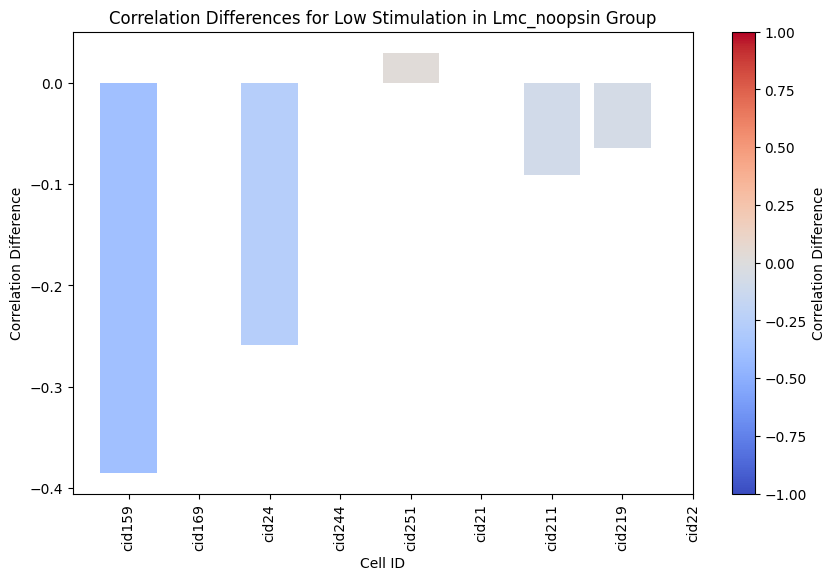

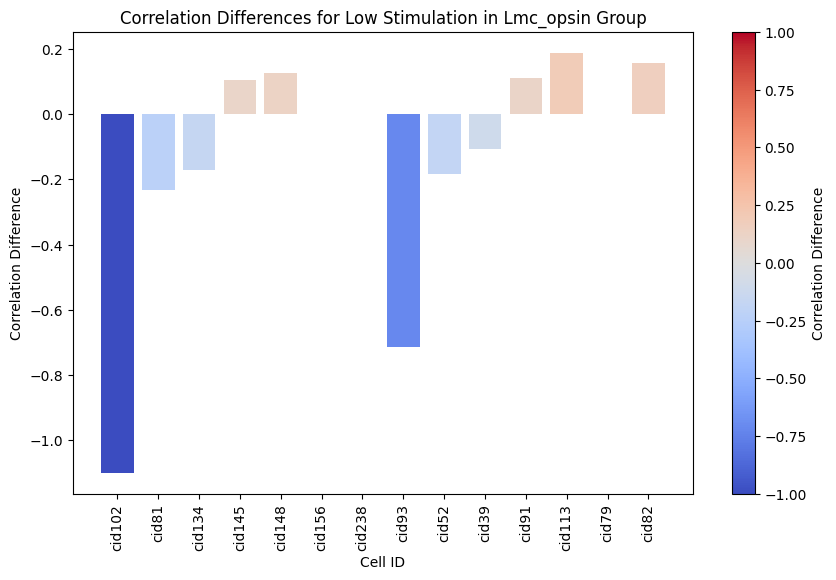

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_correlation_differences(correlation_data, stimulation_level):
    """
    Plot the correlation differences for all units, ranked from least to most, for a specified stimulation level.

    Parameters:
    correlation_data (dict): The dictionary containing the Pearson correlation data for each unit.
    stimulation_level (str): The stimulation level to plot (one of 'Zero', 'Low', 'Mid', 'Max', 'Pooled').

    Returns:
    None: The function will plot the data but not return any values.
    """
    
    # Loop through each group in the correlation data
    for group_name, group_data in correlation_data.items():
        
        # List to store all units and their correlation differences
        all_units_correlation_differences = []

        # Get the 'Pre' epoch data to get the units and their correlation differences
        epoch_data = group_data['Pre']
        
        # Loop through each unit to get its correlation difference for the specified stimulation level
        for unit in epoch_data:
            # Get the correlation difference for the current unit and the specified stimulation level
            correlation_difference = unit[f'{stimulation_level}_Correlation_Difference']
            # Get the cell ID for the current unit
            cell_id = unit['CellID']
            # Add the unit's cell ID and correlation difference to the list
            all_units_correlation_differences.append((cell_id, correlation_difference))
    
        # Sort the units by their correlation differences from least to most
        sorted_units = sorted(all_units_correlation_differences, key=lambda x: x[1])
        
        # Get the cell IDs and correlation differences as separate lists
        cell_ids, correlation_differences = zip(*sorted_units)
        
        # Create a bar plot of the correlation differences
        plt.figure(figsize=(10, 6))
        
        # Create a colormap for the bar colors
        norm = mcolors.Normalize(vmin=-1, vmax=1)  # Setting the range to -1 to 1 as per your request
        cmap = plt.cm.get_cmap('coolwarm')
        
        # Create a bar plot with colors based on the correlation differences
        plt.bar(range(len(correlation_differences)), correlation_differences, tick_label=cell_ids, color=cmap(norm(correlation_differences)))
        
        # Add a colorbar to the plot
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, label='Correlation Difference')
        
        # Add labels and title to the plot
        plt.xlabel('Cell ID')
        plt.ylabel('Correlation Difference')
        plt.title(f'Correlation Differences for {stimulation_level} Stimulation in {group_name} Group')
        
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=90)
        
        # Display the plot
        plt.show()

plot_correlation_differences(pearson_correlations, 'Low')

[('cid24', 0.20177297530284496), ('cid244', 0.04835473683181801), ('cid251', 0.07484108370804907), ('cid211', -0.13899551172137592), ('cid219', 0.18293581913494403), ('cid22', -0.013062762704640567)]


/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/2719739319.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_63552/2719739319.py:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Correlation Difference')


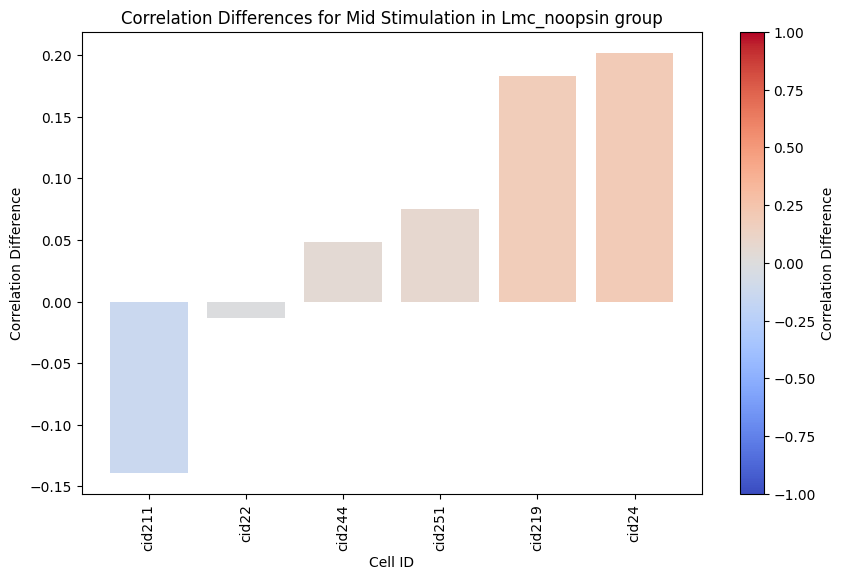

[('cid134', -0.0021241330429874195), ('cid145', -0.26771287358008916), ('cid148', -0.28750680586102795), ('cid238', -0.9188644969228486), ('cid52', -0.22820945268010323), ('cid113', 0.09340035289956283), ('cid82', 0.1426733730997839), ('cid102', 0.2112981483026821), ('cid39', 0.025283434000311522), ('cid81', -0.05687608673949898), ('cid93', -0.6345482947844615)]


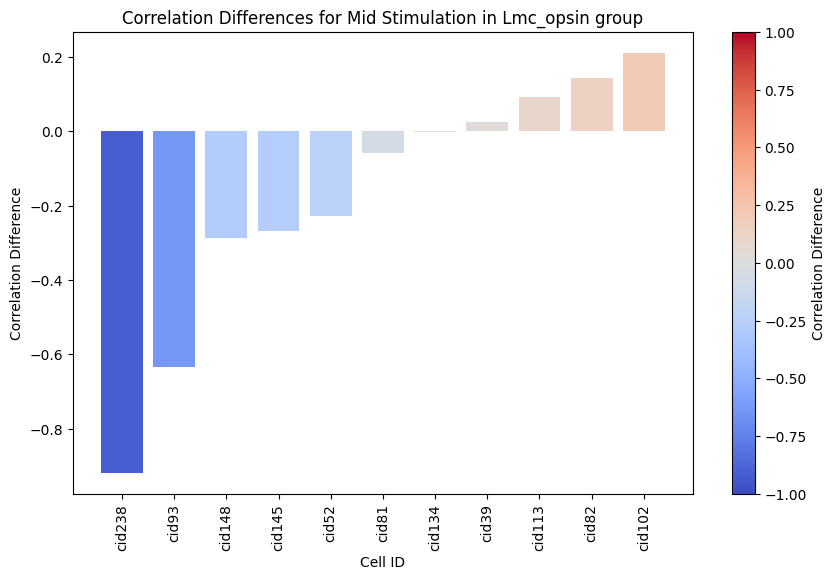

[('cid24', 0.19270775651376912), ('cid251', -0.355972964829604), ('cid219', 0.10516373836549894)]


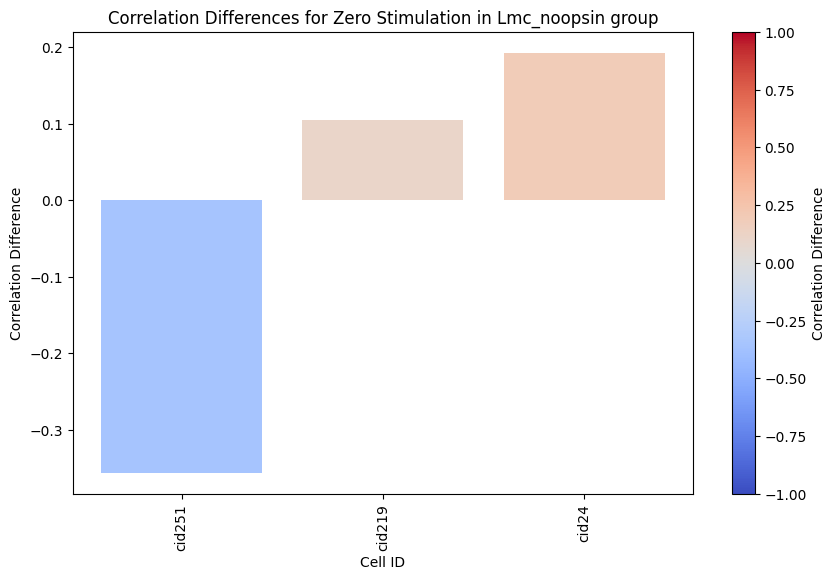

[('cid134', 0.5293668058157355), ('cid145', 0.0587574856011539), ('cid148', 0.0863967939228942), ('cid52', -0.3852032584093581), ('cid79', -0.004101114932208039), ('cid82', -0.14777617106175117), ('cid102', 0.14836464191406742), ('cid39', -0.21270363934956427), ('cid81', -0.011325044109220694), ('cid93', -0.4638700784415832)]


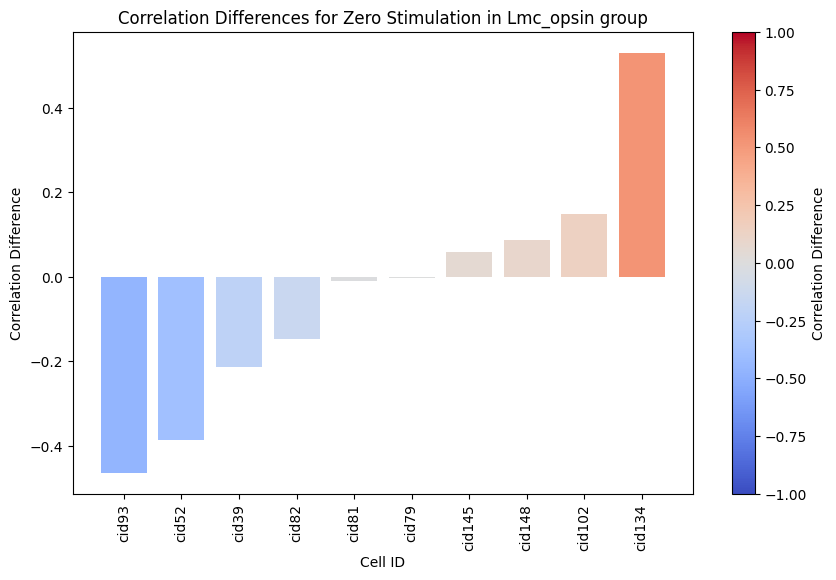

[('cid159', -0.38481626317392603), ('cid24', -0.25838088624281746), ('cid251', 0.02967814399681637), ('cid211', -0.09066388834442007), ('cid219', -0.06457470217822728)]


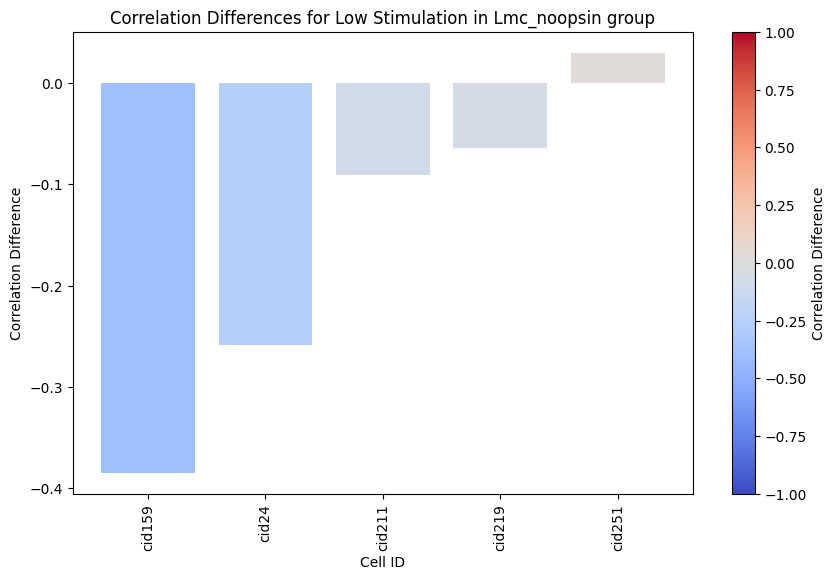

[('cid134', -0.17031784064104055), ('cid145', 0.10647981183914458), ('cid148', 0.12578882932722973), ('cid52', -0.18209285204471934), ('cid91', 0.11206943879356293), ('cid113', 0.18894054537425875), ('cid82', 0.15692614507932484), ('cid102', -1.1010860808458782), ('cid39', -0.10686414256803156), ('cid81', -0.23123959741990294), ('cid93', -0.7133618532363076)]


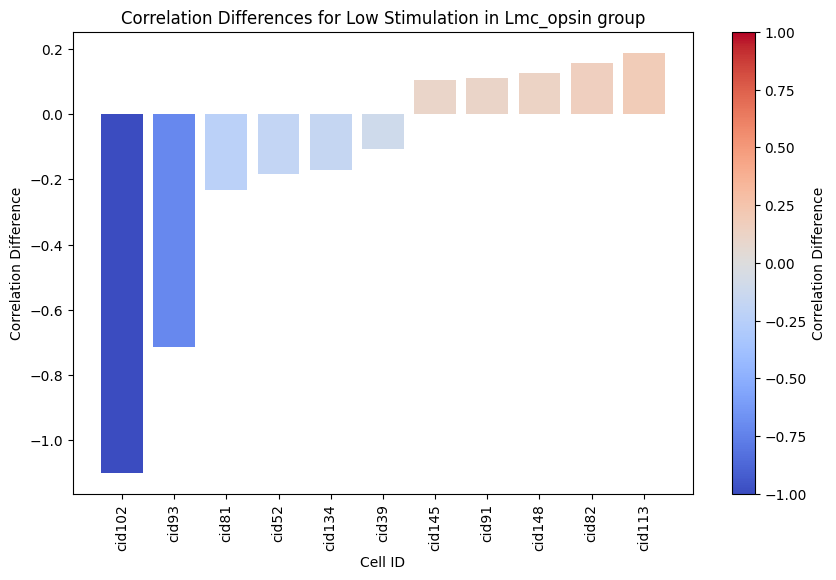

[('cid24', 0.20177297530284496), ('cid244', 0.04835473683181801), ('cid251', 0.07484108370804907), ('cid211', -0.13899551172137592), ('cid219', 0.18293581913494403), ('cid22', -0.013062762704640567)]


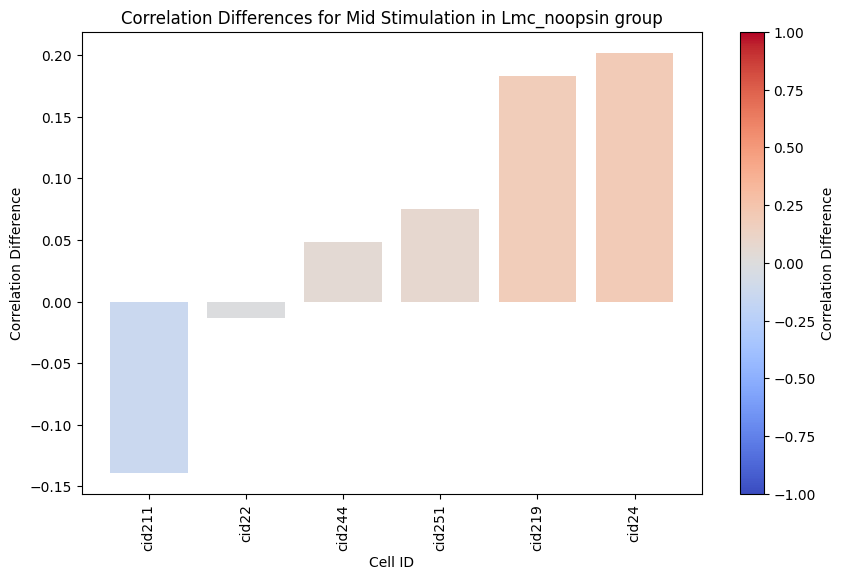

[('cid134', -0.0021241330429874195), ('cid145', -0.26771287358008916), ('cid148', -0.28750680586102795), ('cid238', -0.9188644969228486), ('cid52', -0.22820945268010323), ('cid113', 0.09340035289956283), ('cid82', 0.1426733730997839), ('cid102', 0.2112981483026821), ('cid39', 0.025283434000311522), ('cid81', -0.05687608673949898), ('cid93', -0.6345482947844615)]


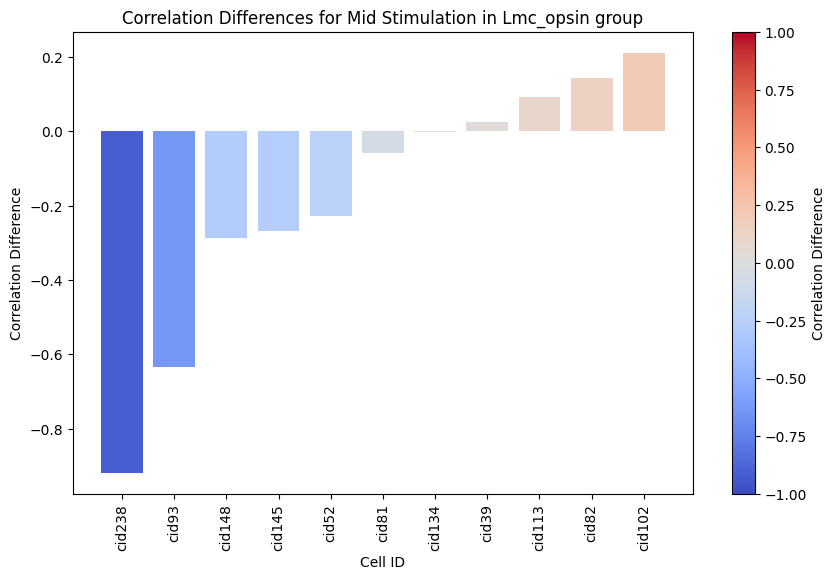

[('cid159', -0.06460986167466788), ('cid169', 0.7796283734672818), ('cid24', 0.15049079704788815), ('cid244', 0.20939070552890127), ('cid251', 0.13579322440353092), ('cid21', 0.39725426214460197), ('cid211', 0.08268866407750702), ('cid219', 0.17789659815782846)]


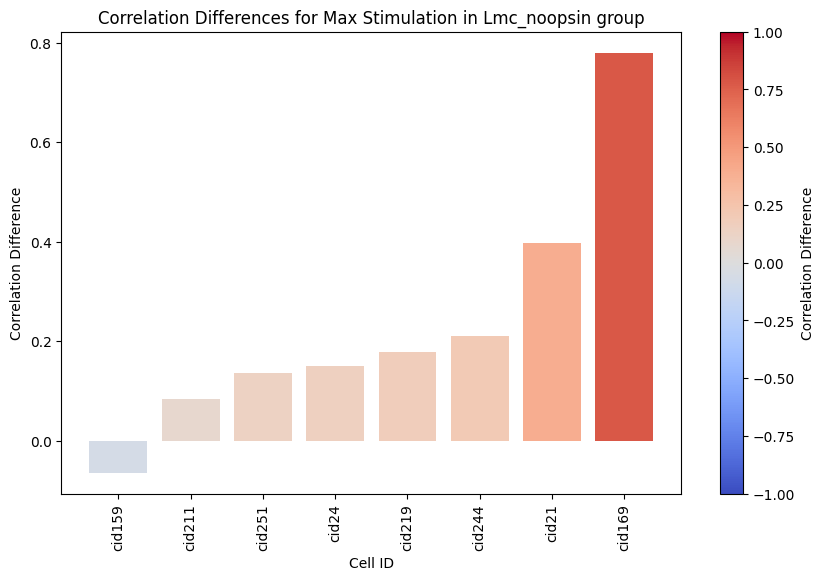

[('cid134', 0.11854181848980269), ('cid145', -0.24038614780778542), ('cid148', -0.1525418057656454), ('cid156', -0.01878278241491931), ('cid52', -0.13517470263776113), ('cid113', -0.13492610506291336), ('cid82', -0.03798564222155766), ('cid102', -0.35307243403527805), ('cid39', 0.15281201772262942), ('cid81', -0.21556185650428333), ('cid93', -0.4820149298502836)]


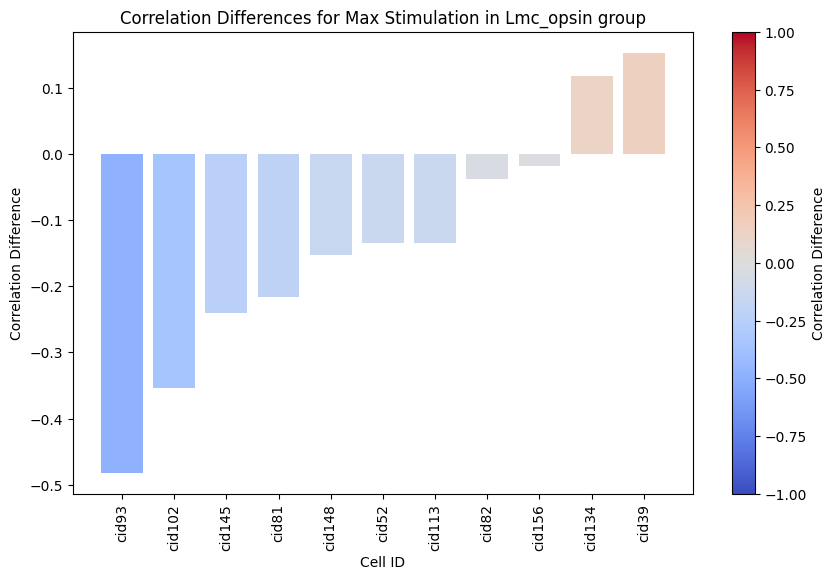

[('cid159', -0.11362387343436128), ('cid169', 0.5211351334358035), ('cid24', 0.05388853294562035), ('cid244', 0.12221177964964769), ('cid251', 0.06443242062720803), ('cid21', 0.2591968360610168), ('cid211', -0.013795472818365535), ('cid219', 0.15787139338428108), ('cid22', -0.01179361396993776)]


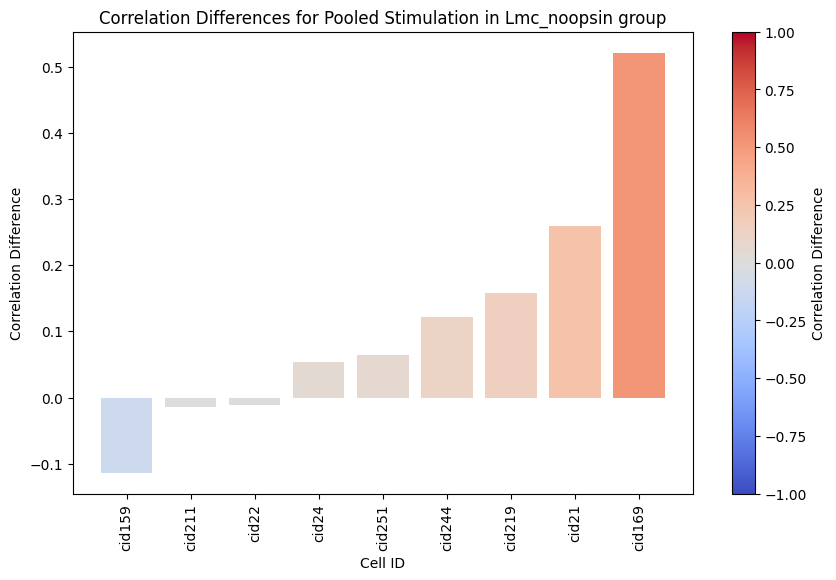

[('cid134', -0.08998685693943898), ('cid145', -0.12408365470323533), ('cid148', -0.08635976904090059), ('cid156', -0.01024836179072314), ('cid238', -0.3848892349665148), ('cid52', -0.19180971190708263), ('cid91', 0.02120450046232107), ('cid113', 0.06418224702627792), ('cid82', 0.08164007894118522), ('cid102', -0.7044745480453729), ('cid39', 0.02875716897307712), ('cid81', -0.19782608294851256), ('cid93', -0.5535919132943726)]


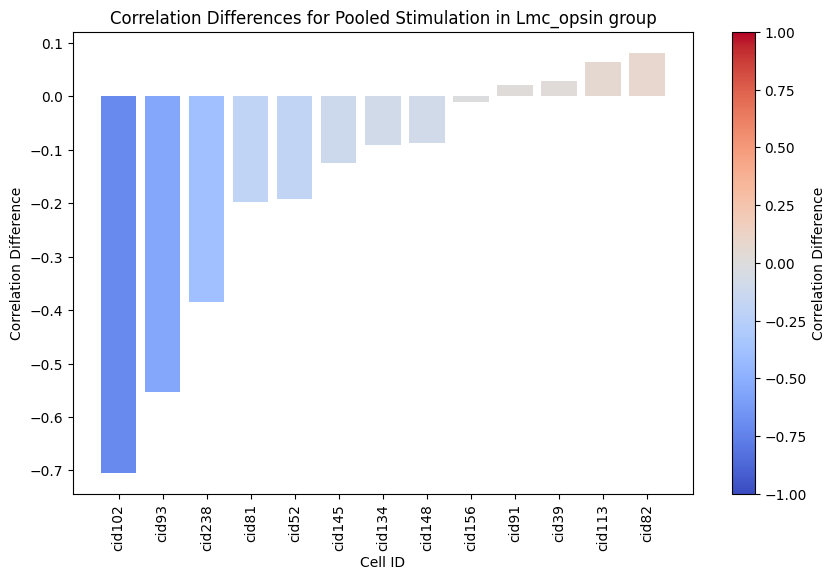

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_correlation_differences(correlation_data, stimulation_level):
    """
    Plot the correlation differences for all units, ranked from least to most, for a specified stimulation level.

    Parameters:
    correlation_data (dict): The dictionary containing the Pearson correlation data for each unit.
    stimulation_level (str): The stimulation level to plot (one of 'Zero', 'Low', 'Mid', 'Max', 'Pooled').

    Returns:
    None: The function will plot the data but not return any values.
    """
    
    # Loop through each group in the correlation data
    for group_name, group_data in correlation_data.items():
        
        # List to store all units and their correlation differences
        all_units_correlation_differences = []

        # Loop through each unit in the 'Pre' epoch to get its correlation difference for the specified stimulation level
        for unit in group_data['Pre']:
            # Get the correlation difference for the current unit and the specified stimulation level
            correlation_difference = unit.get(f'{stimulation_level}_Correlation_Difference')
            
            # Skip units with invalid correlation differences
            if correlation_difference is None or np.isnan(correlation_difference):
                continue
            
            # Get the cell ID for the current unit
            cell_id = unit['CellID']
            
            # Add the unit's cell ID and correlation difference to the list
            all_units_correlation_differences.append((cell_id, correlation_difference))
        
        # Print the list of units and their correlation differences
        print(all_units_correlation_differences)  

        # Sort the units by their correlation differences from least to most
        sorted_units = sorted(all_units_correlation_differences, key=lambda x: x[1])
        
        # Get the cell IDs and correlation differences as separate lists
        cell_ids, correlation_differences = zip(*sorted_units)
        
        # Create a bar plot of the correlation differences
        plt.figure(figsize=(10, 6))
        
        # Create a colormap for the bar colors
        norm = mcolors.Normalize(vmin=-1, vmax=1)
        cmap = plt.cm.get_cmap('coolwarm')
        
        # Create a bar plot with colors based on the correlation differences
        plt.bar(range(len(correlation_differences)), correlation_differences, tick_label=cell_ids, color=cmap(norm(correlation_differences)))
        
        # Add a colorbar to the plot
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, label='Correlation Difference')
        
        # Add labels and title to the plot
        plt.xlabel('Cell ID')
        plt.ylabel('Correlation Difference')
        plt.title(f'Correlation Differences for {stimulation_level} Stimulation in {group_name} group')
        
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=90)
        
        # Display the plot
        plt.show()



plot_correlation_differences(pearson_correlations, 'Mid')

#loop over the stimulation levels
for stimulation_level in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']:
    plot_correlation_differences(pearson_correlations, stimulation_level)
